In [8]:
# initial setup
import os
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import shutil
from oper_postprocess.post_process import *
from scipy.stats.qmc import LatinHypercube as LH
from scipy import stats
import seaborn as sns

file_path = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\validation\SILVER")
output_dir = fixpath(".")

scenarios = pd.DataFrame([name for name in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, name))])
print(scenarios)

#General plot settings

gen_types = {
    'hydro': 'Hydro',
    'Wind': 'Wind',
    'Solar': 'Solar',
    'gasCC': 'Gas CC',
    'gasccs': 'Gas CCS',
    'coalccs': 'Coal CCS',
    'SMR': 'SMR',
    'Nuclear': 'Nuclear',
    'gasSC': 'Gas SC',
    'coal' : 'Coal',
    'diesel': 'Diesel',
    'biomass': 'Biomass',
    'Biomass': 'Biomass',
    'PHS': 'PHS',
    'LB': 'LB',
    'NG': 'Gas CC'
}

colors = {
    'hydro': '#a1c5ff',
    'Wind': '#a9d6ae',
    'Solar': '#fcfba9',
    'Wind': '#a9d6ae',
    'gasCC': '#a3a3a3',
    'gasccs': '#a3a3a3',
    'NG': '#a3a3a3',
    'coalccs': '#a3a3a3',
    'SMR': '#a36594',
    'Nuclear': '#664264',
    'gasSC': '#454545',
    'coal' : '#0d0d0d',
    'diesel': '#707070',
    'Biomass': '#a8b3a2',
    'biomass': '#a8b3a2',
    'PHS': '#c4fcff',
    'LB': '#b8c3fc'
}

Empty DataFrame
Columns: []
Index: []


In [6]:
# Validating the supply demand balance

for dir in scenarios[0]:
       
        file_name = dir.split('_')[2]
        hourly_dispatch = pd.read_excel(f'{dir}/analysis_BC_Cascade_{file_name}.xlsx',sheet_name='Total Dispatch' , index_col=0)
        hourly_dispatch = hourly_dispatch.drop('total', axis=0)

        load_curve = pd.read_excel(fixpath(fr"C:\SILVER_BC_Cascade\SILVER_Data\user_inputs\BC_Cascade_Demand_Real_Forecasted_{file_name}.xlsx"), sheet_name='Province_Total_Real', index_col=0)
        load_curve = load_curve.loc[:,'demand']
        load_curve = load_curve.iloc[0:len(hourly_dispatch)]
        load_curve.index = hourly_dispatch.index
        load_curve = load_curve

        if 'cascade' in hourly_dispatch.columns:
                hourly_dispatch.hydro = hourly_dispatch.hydro + hourly_dispatch.cascade
                hourly_dispatch = hourly_dispatch.drop('cascade', axis=1)
        if 'Dummy' in hourly_dispatch.columns:
                hourly_dispatch = hourly_dispatch.drop('Dummy', axis=1)
        if 'dummy' in hourly_dispatch.columns:
                hourly_dispatch = hourly_dispatch.drop('dummy', axis=1)
        if 'storage' in hourly_dispatch.columns:
                hourly_dispatch = hourly_dispatch.drop('storage', axis=1)
        if 'import' in hourly_dispatch.columns:
                hourly_dispatch = hourly_dispatch.drop('import', axis=1)

        hourly_dispatch['Wind'] = hourly_dispatch['Wind'] + load_curve - hourly_dispatch.sum(axis=1)

        if 'Nuclear' in hourly_dispatch.columns:
                cols = ['Nuclear', 'hydro', 'Biomass', 'Wind', 'Solar']
                hourly_dispatch = hourly_dispatch[cols]

        starthour = 384
        endhour = 600
        hourly_dispatch = hourly_dispatch.iloc[starthour:starthour+endhour]
        load_curve = load_curve.iloc[starthour:starthour+endhour]


        fig, ax = plt.subplots(figsize=(8,4))
        lns1 = ax.stackplot(hourly_dispatch.index, hourly_dispatch.values.T, labels=[gen_types[key] for key in list(hourly_dispatch.columns)], colors=[colors[keyc] for keyc in list(hourly_dispatch.columns)]
                , baseline='zero', lw=0.5, edgecolor='white')
        ax.set(ylabel='Generation (MW)')
        ax.tick_params(axis='x', rotation=45)
        ax2 = ax.twinx()
        lns2 = ax2.plot(load_curve, color='black', label='Load', alpha=0.5)
        ax2.set(yticklabels=[])
        ax2.set(ylim=(0, ax.get_ylim()[1]))
        #ax2.legend(loc='lower right', bbox_to_anchor=(.973, 0.36))
        lns = lns1 + lns2 
        labs = [l.get_label() for l in lns]
        plt.title('Demand and supply balacne in hourly dispatch')
        ax.legend(lns, labs, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.35))


        plt.savefig(f'{dir}/valid_hourly_dispatch.jpg', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

In [44]:
# validating pmin and pmax of generators (except hydro)
for dir in scenarios[0]:
        file_name = dir.split('_')[2]
        gen_dispatch = pd.read_excel(f'{dir}/analysis_BC_Cascade_{file_name}.xlsx',sheet_name='UC Results' , index_col=0)
        try :
                gen_dispatch = hourly_dispatch.drop('total', axis=0)
        except:
                pass
        max_gen = pd.read_excel(fixpath(fr"C:\SILVER_BC_Cascade\SILVER_Data\user_inputs\model inputs - BC_cascade_{file_name}.xlsx"), sheet_name='non-vre plants', index_col=0)
        max_gen = max_gen.loc[(max_gen['name'].str.contains('NG') | 
                               max_gen['name'].str.contains('biomass') |
                               max_gen['name'].str.contains('nuclear') |
                               max_gen['name'].str.contains('Nuclear') |
                               max_gen['name'].str.contains('Biomass')),['[MW]', 'pmin']]
        for gen in max_gen.index:
                try:
                        plant_dis = gen_dispatch.loc[:,gen]
                except:
                        print(f'{gen} is not found in the dispatch')                
                else:
                        plant_dis = plant_dis.iloc[100:200]
                        plant_max = max_gen.loc[gen, '[MW]']
                        plant_min = max_gen.loc[gen, 'pmin']
                        if (plant_dis == plant_dis.iat[0]).all():
                                print(f'{gen} is continously dispatched')
                        else:
                                fig, ax = plt.subplots(figsize=(8,4))
                                lns1 = ax.plot(plant_dis, color='black', label="Plant's hourly generation (MW)", linewidth=0.4)
                                handles, labels = ax.get_legend_handles_labels()
                                lns2 = ax.hlines(y=plant_max,xmin=plant_dis.index[0], xmax=plant_dis.index[-1], color='r', linestyle='--'
                                                , label='Maximum capacity')
                                lns3 = ax.hlines(y=plant_min,xmin=plant_dis.index[0], xmax=plant_dis.index[-1], color='green', linestyle='--'
                                                , label='Minimum output')
                                ax.tick_params(axis='x', rotation=45)
                                ax.legend(handles=[Line2D([], [], color="black", label=f"Hourly output", linewidth=0.4)
                                                , Line2D([0], [0], color="r", label=lns2.get_label(), linestyle='--')
                                                , Line2D([0], [0], color="g", label=lns3.get_label(), linestyle='--')]
                                                , loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=3)
                                plt.title(f'Hourly output minimum and maximum constraints for {gen.split("_")[0]}')
                                plt.savefig(f'{dir}/{gen}_valid_max_gen.png', dpi=300, bbox_inches='tight')
                                plt.close()


NG_CC_1 is continously dispatched
biomass_1 is continously dispatched
biomass_2 is continously dispatched
biomass_3 is continously dispatched
biomass_4 is continously dispatched
NG_CC_2 is continously dispatched
NG_CC_4 is continously dispatched
NG_CC_6 is continously dispatched
NG_CC_10 is continously dispatched
NG_CC_12 is continously dispatched
Biomass_5 is continously dispatched
Biomass_6 is continously dispatched
Biomass_8 is continously dispatched
Biomass_16 is continously dispatched
Biomass_5 is continously dispatched
Biomass_6 is continously dispatched
Biomass_12 is continously dispatched
Biomass_16 is continously dispatched
Biomass_17 is continously dispatched
Biomass_5 is continously dispatched
Biomass_6 is continously dispatched
Biomass_8 is continously dispatched
Biomass_16 is continously dispatched
Biomass_17 is continously dispatched
Biomass_5 is continously dispatched
Biomass_8 is continously dispatched
Biomass_16 is continously dispatched
Biomass_5 is continously dispat

In [66]:
# Validating the hydro minimum constraint in the last chapter
scenarios_hydro = scenarios.loc[scenarios[0].str.contains('TK')]

for dir in scenarios_hydro[0]:
        file_name = dir.split('_')[2]
        max_gen = pd.read_excel(fixpath(fr"C:\SILVER_BC_Cascade\SILVER_Data\user_inputs\model inputs - BC_cascade_{file_name}.xlsx"), sheet_name='non-vre plants', index_col=0)
        hydro_dispatch = pd.read_excel(f'{dir}/analysis_BC_Cascade_{file_name}.xlsx',sheet_name='UC Results' , index_col=0)
        min_cascade = pd.read_csv(fixpath(r"C:\SILVER_BC_Cascade\SILVER_Data\user_inputs\Hydro_Data-BC_Cascade\hydro_cascade_pmin - TK.csv"), index_col=0)
        min_cascade = min_cascade.iloc[0:len(hydro_dispatch)].set_index(hydro_dispatch.index, drop= True)
        min_hourly = pd.read_csv(fixpath(r'C:\SILVER_BC_Cascade\SILVER_Data\user_inputs\Hydro_Data-BC_Cascade\hydro_hourly_pmin - TK.csv'), index_col=0)
        min_hourly = min_hourly.iloc[0:len(hydro_dispatch)].set_index(hydro_dispatch.index, drop= True)
        for cas_gen in min_cascade.columns:
                hydro_dispatch_gen = hydro_dispatch[cas_gen].iloc[0:1440]
                min_cascade_gen = min_cascade[cas_gen].iloc[0:1440]
                plant_max = max_gen.loc[cas_gen, '[MW]']
                fig, ax = plt.subplots(figsize=(8,4))
                lns1 = ax.plot(hydro_dispatch_gen, color='#a1c5ff', label="Hydropower hourly generation (MW)",
                               linewidth=0.5)
                handles, labels = ax.get_legend_handles_labels()
                lns2 = ax.plot(min_cascade_gen, color='green', linestyle='--'
                                , label='Minimum output')
                lns3 = ax.hlines(y=plant_max,xmin=hydro_dispatch_gen.index[0], 
                                 xmax=hydro_dispatch_gen.index[-1], color='r', linestyle='--',
                                 label='Maximum capacity')
                ax.tick_params(axis='x', rotation=45)
                ax.legend(handles=[Line2D([], [], color="#a1c5ff", label=f"Hourly output", linewidth=0.4)
                                , Line2D([0], [0], color="green", label='Minimum output', linestyle='--')
                                , Line2D([0], [0], color="r", label=lns3.get_label(), linestyle='--')]
                                , loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=3)
                plt.title(f'Hourly output compared to minimum constraints')
                plt.savefig(f'{dir}/{cas_gen}_valid_min_gen_cascade.png', dpi=300, bbox_inches='tight')
                plt.close()
        for hour_gen in min_hourly.columns:
                hydro_dispatch_gen = hydro_dispatch[hour_gen].iloc[0:1440]
                min_cascade_gen = min_hourly[hour_gen].iloc[0:1440]
                fig, ax = plt.subplots(figsize=(8,4))
                lns1 = ax.plot(hydro_dispatch_gen, color='#a1c5ff', label="Hydropower hourly generation (MW)",
                               linewidth=0.5)
                handles, labels = ax.get_legend_handles_labels()
                lns2 = ax.plot(min_cascade_gen, color='green', linestyle='--'
                                , label='Planned output', linewidth=0.5)
                ax.tick_params(axis='x', rotation=45)
                ax.legend(handles=[Line2D([], [], color="#a1c5ff", label=f"Hourly output", linewidth=0.4)
                                , Line2D([0], [0], color="green", label='Planned output', linestyle='--')]
                                , loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=2)
                plt.title(f'Hourly output compared to minimum constraints')
                plt.savefig(f'{dir}/{hour_gen}_valid_min_gen_hourly.png', dpi=300, bbox_inches='tight')
                plt.close()

In [77]:
# Validating the hydro minimum constraint in the last chapter
dir = scenarios.loc[26,0]

file_name = dir.split('_')[2]
vre_avail = pd.read_excel(f'{dir}/analysis_BC_Cascade_{file_name}.xlsx',sheet_name='Available VRE' , index_col=0)
vre_dispatch = pd.read_excel(f'{dir}/analysis_BC_Cascade_{file_name}.xlsx',sheet_name='UC VRE Results' , index_col=0)

for wind in vre_avail.columns[vre_avail.columns.str.contains('Wind')]:
        vre_avail_gen = vre_avail[wind].iloc[0:120]
        vre_dispatch_gen = vre_dispatch[wind].iloc[0:120]
        fig, ax = plt.subplots(figsize=(8,4))
        lns1 = ax.plot(vre_dispatch_gen,  color=colors['Wind'], label="Wind hourly generation (MW)",
                        linewidth=0.5)
        handles, labels = ax.get_legend_handles_labels()
        plt.fill_between(vre_dispatch_gen.index, vre_dispatch_gen, 0,  color=colors['Wind'], alpha=0.5)
        lns2 = ax.plot(vre_avail_gen, color='red', linestyle='--'
                        , label='Maximum capacity factor', linewidth=0.5)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(handles=[Line2D([], [], color=colors['Wind'], label=f"Hourly output", linewidth=0.4)
                        , Line2D([0], [0], color="red", label='Maximum output', linestyle='--')]
                        , loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=2)
        plt.title(f'Hourly output compared to maximum available wind')
        plt.savefig(f'{dir}/{wind}_valid_max_wind.png', dpi=300, bbox_inches='tight')
        plt.close()
for solar in vre_avail.columns[vre_avail.columns.str.contains('Solar')]:
        vre_avail_gen = vre_avail[solar].iloc[0:120]
        vre_dispatch_gen = vre_dispatch[solar].iloc[0:120]
        fig, ax = plt.subplots(figsize=(8,4))
        lns1 = ax.plot(vre_dispatch_gen,  color=colors['Solar'], label="Solar hourly generation (MW)",
                        linewidth=0.5)
        handles, labels = ax.get_legend_handles_labels()
        plt.fill_between(vre_dispatch_gen.index, vre_dispatch_gen, 0,  color=colors['Solar'], alpha=0.5)
        lns2 = ax.plot(vre_avail_gen, color='red', linestyle='--'
                        , label='Maximum capacity factor', linewidth=0.5)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(handles=[Line2D([], [], color=colors['Solar'], label=f"Hourly output", linewidth=0.4)
                        , Line2D([0], [0], color="red", label='Maximum output', linestyle='--')]
                        , loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=2)
        plt.title(f'Hourly output compared to maximum available solar')
        plt.savefig(f'{dir}/{solar}_valid_max_solar.png', dpi=300, bbox_inches='tight')
        plt.close()

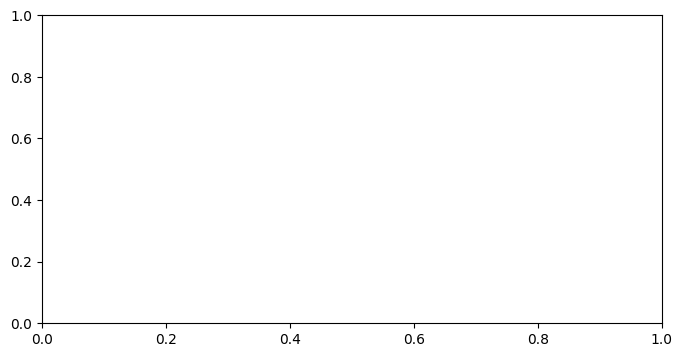

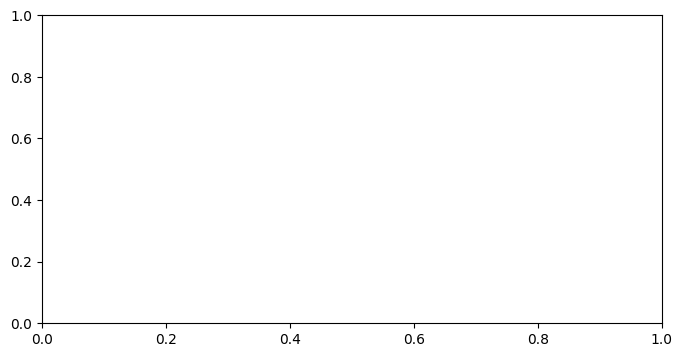

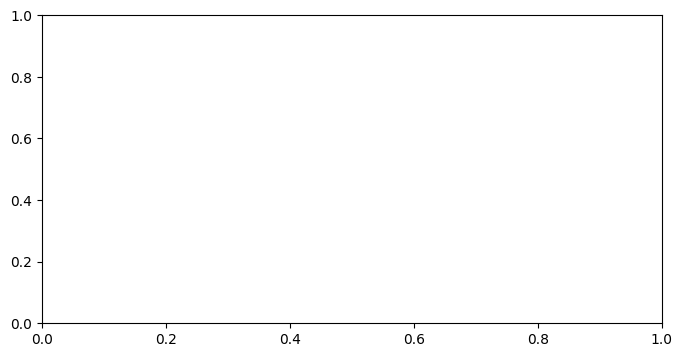

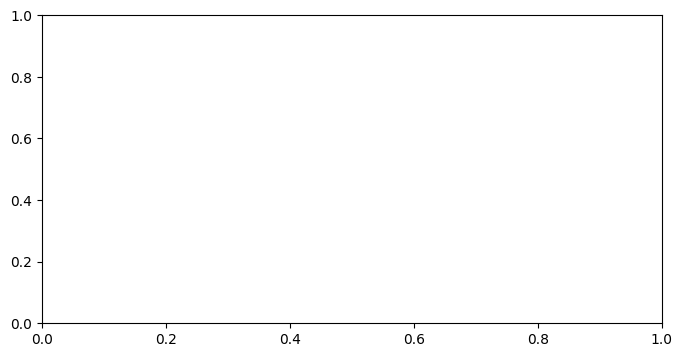

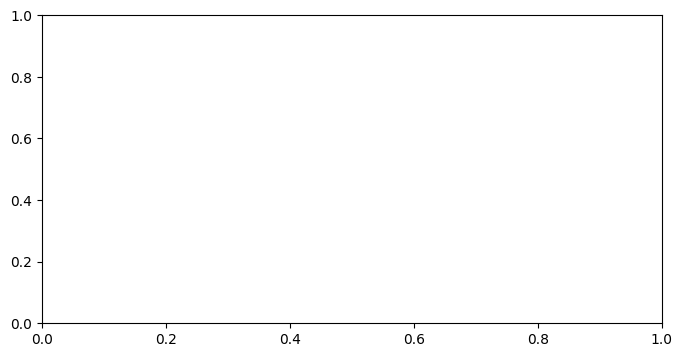

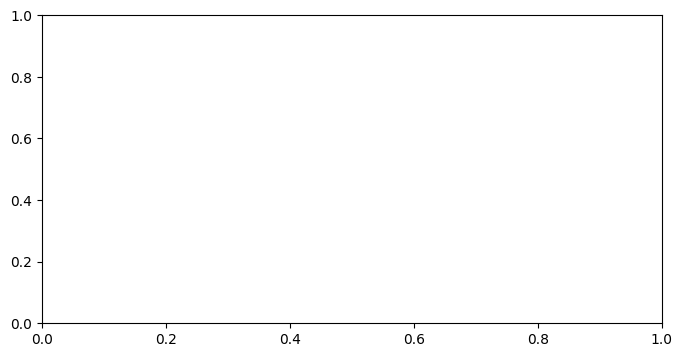

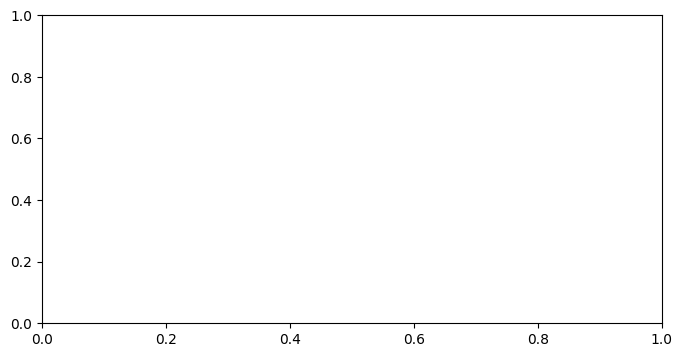

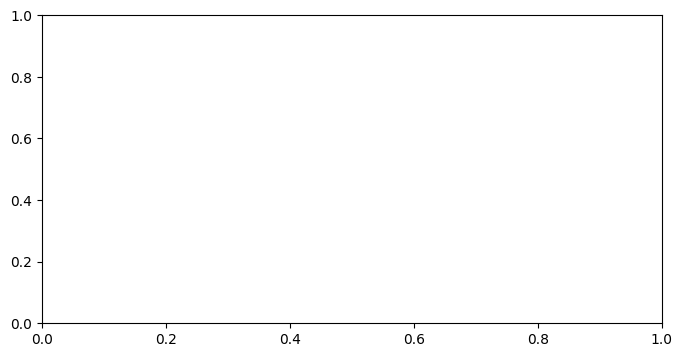

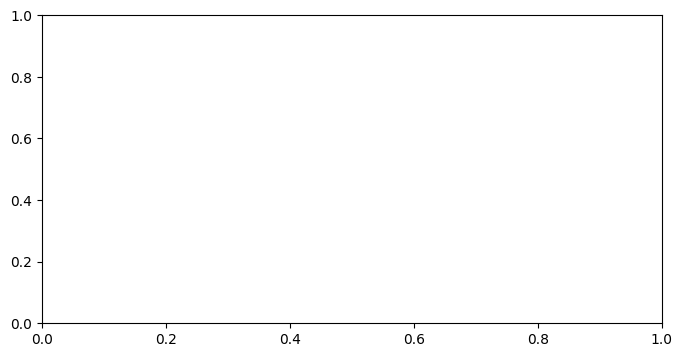

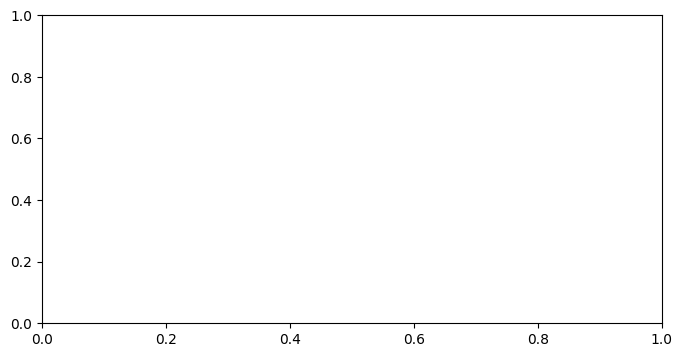

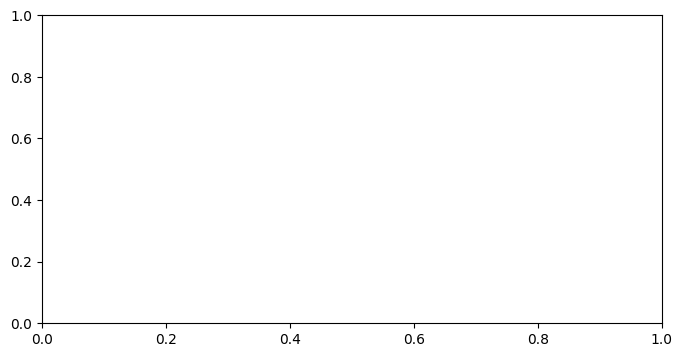

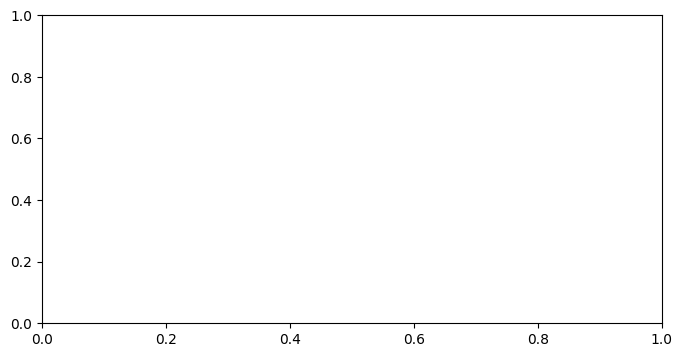

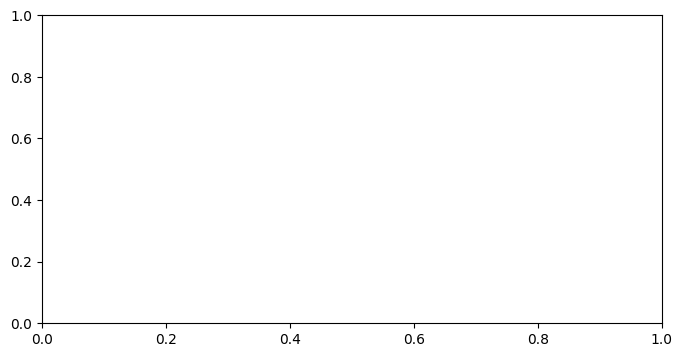

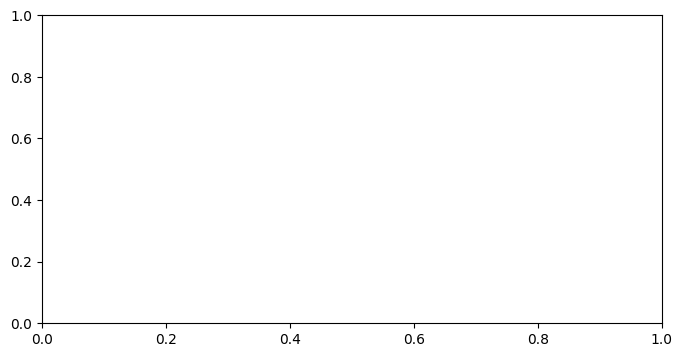

In [84]:
#Testing for the line capacity constraint

file_name = dir.split('_')[2]
line_flow = pd.read_excel(f'{dir}/analysis_BC_Cascade_{file_name}.xlsx',sheet_name='Line Flow' , index_col=0)

for i, name in enumerate(line_flow.columns):
        fig, ax = plt.subplots(figsize=(8,4))
        lf_i = line_flow.iloc[3:123,i]
        lf_max = max(lf_i.max(), abs(lf_i.min()))
        lf_min = -lf_max
        fig, ax = plt.subplots(figsize=(8,4))
        lns1 = ax.plot(lf_i, color='black', label="Hourly line flow (MW)", linewidth=0.5)
        handles, labels = ax.get_legend_handles_labels()
        lns2 = ax.hlines(y=lf_max,xmin=lf_i.index[0], xmax=lf_i.index[-1], color='r', linestyle='--'
                        , label='Maximum capacity')
        lns3 = ax.hlines(y=lf_min,xmin=lf_i.index[0], xmax=lf_i.index[-1], color='r', linestyle='--'
                        , label='Minimum capacity')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(handles=[Line2D([], [], color="black", label=f"Hourly line flow", linewidth=0.5)
                        , Line2D([0], [0], color="r", label=lns2.get_label(), linestyle='--')
                        , Line2D([0], [0], color="r", label=lns3.get_label(), linestyle='--')]
                        , loc='upper center', bbox_to_anchor=(0.5, -0.23), ncol=3)
        plt.title(f'Hourly lineflow compared minimum and maximum constraints')
        plt.savefig(f'{dir}/{i}_valid_minmax_lineflow.png', dpi=300, bbox_inches='tight')
        plt.close()

In [28]:
# SA for wind and solar cf - reading inputs

silver_path = fixpath(r'C:\SILVER_BC_Cascade\SILVER_Data\user_inputs')

list_plants = pd.read_excel(f'{silver_path}/model inputs - BC_cascade_scen12.xlsx', sheet_name='vre plants')
wind_list = list_plants.loc[list_plants['name'].str.contains('Wind'), ['name', '[MW]', 'latitude_MERRA', 'longitude_MERRA']]
solar_list = list_plants.loc[list_plants['name'].str.contains('Solar'), ['name', '[MW]', 'latitude_MERRA', 'longitude_MERRA']]

In [102]:
# random sampling for wind and solar cf
from scipy.stats.qmc import LatinHypercube as LH

# Create a Latin Hypercube sampler
engine = LH(1)

cf_rand = list(engine.random(20))
cf_rand_df = pd.DataFrame(cf_rand, columns=['CapacityFactor'])
cf_rand_df.to_csv('windcf_rand.csv')

for i, rand in enumerate(cf_rand):
    for index, row in wind_list.iterrows():
        lat = row['latitude_MERRA']
        lon = row['longitude_MERRA']
        wind_cf_base = pd.read_csv(f"{silver_path}/VRE_Resource_Analysis/Wind_Generation_Data/{lat}-{lon}/Wind_Generation_Data_{lat}-{lon}_2018.csv", index_col=0)
        wind_cf = wind_cf_base['CapacityFactor'] * rand
        new_dir = f"{silver_path}/VRE_Resource_Analysis_sa_{i}/Wind_Generation_Data/{lat}-{lon}"
        os.makedirs(new_dir, exist_ok=True)
        wind_cf.to_csv(f"{new_dir}/Wind_Generation_Data_{lat}-{lon}_2018.csv")

    for index, row in solar_list.iterrows():
        lat = row['latitude_MERRA']
        lon = row['longitude_MERRA']
        solar_cf_base = pd.read_csv(f"{silver_path}/VRE_Resource_Analysis/Solar_Generation_Data/{lat}-{lon}/Solar_Generation_Data_{lat}-{lon}_2018.csv", index_col=0)
        solar_cf = solar_cf_base['CapacityFactor'] * rand
        new_dir = f"{silver_path}/VRE_Resource_Analysis_sa_{i}/Solar_Generation_Data/{lat}-{lon}"
        os.makedirs(new_dir, exist_ok=True)
        solar_cf.to_csv(f"{new_dir}/Solar_Generation_Data_{lat}-{lon}_2018.csv")

In [5]:
import sys
print(sys.path)

['/mnt/c/users/smoha/documents/git/etl-visuals/validation', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/smoha/.virtualenvs/etl-env/lib/python3.8/site-packages']


In [1]:
# SA for wind and solar cf - analyzing outputs
from oper_postprocess.post_process import *


dest = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\validation\SILVER")
for i in range(0,19):
    silver_postprocess(destination_dir=dest, scenario=f'sahydro_{i}')

NameError: name 'fixpath' is not defined

In [13]:
wind_output = pd.DataFrame(columns=['Wind'])
solar_output = pd.DataFrame(columns=['Solar'])

for i in range (0, 19):
    gen_vre_output = pd.read_excel(f'{dest}/sa_{i}/analysis_BC_Cascade_sa_{i}.xlsx', sheet_name='Total Dispatch', index_col=0)
    wind_output.loc[i] = gen_vre_output.loc['total', 'Wind']
    solar_output.loc[i] = gen_vre_output.loc['total', 'Solar']

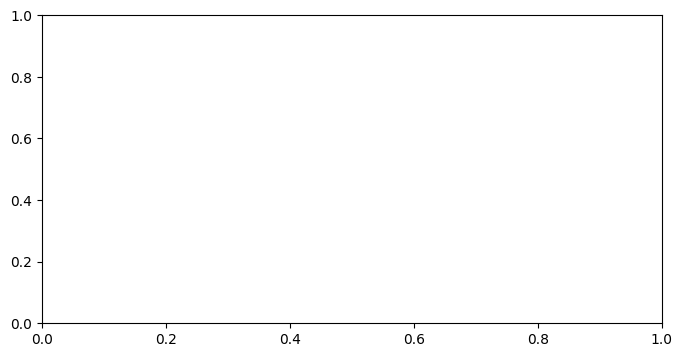

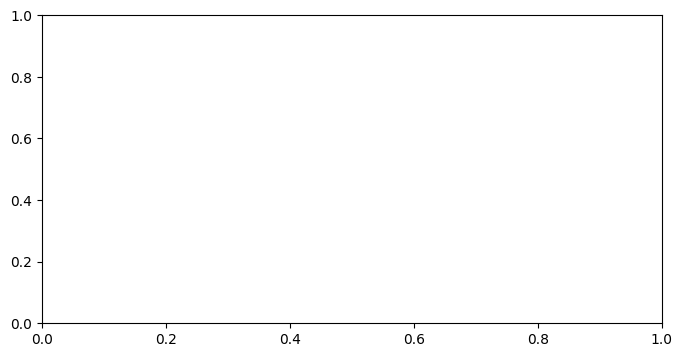

In [19]:
from scipy import stats
import seaborn as sns

cf_rand_df = pd.read_csv('windcf_rand.csv', index_col=0)
merged_df = wind_output.merge(cf_rand_df, left_index=True, right_index=True).merge(solar_output, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(8,4))
r, p = stats.pearsonr(merged_df['CapacityFactor'], merged_df['Wind'])
sns.lmplot(x='CapacityFactor', y='Wind', data=merged_df)
plt.text(0.5, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.title('Wind output vs. capacity factor')
plt.xlabel('Scaling factor for the wind potential')
plt.ylabel('Total wind generation (MWh)')

plt.savefig(f'{dest}/wind_cf_SA.jpg', dpi=300, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(figsize=(8,4))
r, p = stats.pearsonr(merged_df['CapacityFactor'], merged_df['Solar'])
sns.lmplot(x='CapacityFactor', y='Solar', data=merged_df)
plt.text(0.5, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.title('Solar output vs. capacity factor')
plt.xlabel('Scaling factor for the solar potential')
plt.ylabel('Total solar generation (MWh)')

plt.savefig(f'{dest}/solar_cf_SA.jpg', dpi=300, bbox_inches='tight')
plt.close()

In [61]:
# reading max capacities for hydro 
from scipy.stats.qmc import LatinHypercube as LH
engine = LH(1)
hydro_cf_rand = list(engine.random(1))
cf_rand_df = pd.DataFrame(hydro_cf_rand, columns=['CapacityFactor'])
cf_rand_df.to_csv('hydrocf_rand.csv')
list_plants = pd.read_excel(f'{silver_path}/model inputs - BC_cascade_scen12.xlsx', sheet_name='non-vre plants')
cas_list = list_plants.loc[list_plants['name'].str.contains('cascade'), ['name', '[MW]']].transpose()
cas_list.columns = cas_list.iloc[0]
ror_list = list_plants.loc[list_plants['name'].str.contains('hourly'), ['name', '[MW]']].transpose()
ror_list.columns = ror_list.iloc[0]
cas_cf_base = pd.read_csv(f"{silver_path}/Hydro_Data-BC_Cascade/hydro_cascade_pmin - saf.csv", index_col=0)
ror_cf_base = pd.read_csv(f"{silver_path}/Hydro_Data-BC_Cascade/hydro_hourly_pmin - saf.csv", index_col=0)

In [74]:
# SA for hydro cf - random inputs
hydro_cf_rand = list(engine.random(20))
cf_rand_df = pd.DataFrame(hydro_cf_rand, columns=['CapacityFactor'])
cf_rand_df.to_csv('hydrocf_rand.csv')

cas_cf_new = cas_cf_base.iloc[0:743,:].sample(n=round(0.1*len(cas_cf_base.columns)), axis='columns').sample(n=round(0.1*len(cas_cf_base.index[0:744])), axis='index')
ror_cf_sample = ror_cf_base.iloc[0:743,:].sample(n=round(0.2*len(ror_cf_base.columns)), axis='columns').sample(n=round(0.1*len(ror_cf_base.index[0:744])), axis='index')

for i, rand in enumerate(hydro_cf_rand):
    cas_cf_base = pd.read_csv(f"{silver_path}/Hydro_Data-BC_Cascade/hydro_cascade_pmin - saf.csv", index_col=0)
    cas_cf_ch = cas_cf_base
    for cas in cas_cf_new:
        cas_cf_new[cas] = round((0.40 * cas_list.at['[MW]', cas]) * rand[0], 2)
    for index in cas_cf_new.index:
        for col in cas_cf_new.columns:
            cas_cf_ch.at[index, col] = cas_cf_new.at[index, col]
    new_dir=f"{silver_path}/Hydro_Data-BC_Cascade_sahydro_{i}"
    shutil.copytree(f"{silver_path}/Hydro_Data-BC_Cascade", new_dir, dirs_exist_ok=True)
    cas_cf_ch.to_csv(f"{new_dir}/hydro_cascade_pmin.csv")

    '''ror_cf_base = pd.read_csv(f"{silver_path}/Hydro_Data-BC_Cascade/hydro_hourly_pmin - saf.csv", index_col=0)
    ror_cf_ch = ror_cf_base
    for ror in ror_cf_sample:
        ror_cf_sample[ror] = round((0.55 * ror_list.at['[MW]', ror]) * rand[0], 2)
    for index in ror_cf_sample.index:
        for col in ror_cf_sample.columns:
            ror_cf_ch.at[index, col] = ror_cf_sample.at[index, col]
    ror_cf_ch.to_csv(f"{new_dir}/hydro_hourly_pmin.csv")'''

In [92]:
# SA for hydro cf - reading outputs
hydro_output = pd.DataFrame(columns=['hydro'])
vre_output = pd.DataFrame(columns=['vre'])

for i in range (0, 19):
    gen_output = pd.read_excel(f'{dest}/sahydro_{i}/analysis_BC_Cascade_sahydro_{i}.xlsx', sheet_name='Total Dispatch', index_col=0)
    hydro_output.loc[i] = gen_output.loc['total', 'hydro']
    vre_output.loc[i] = gen_output.at['total', 'Wind'] + gen_output.at['total', 'Solar']

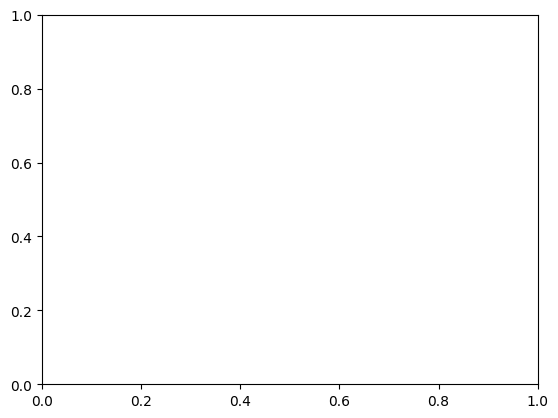

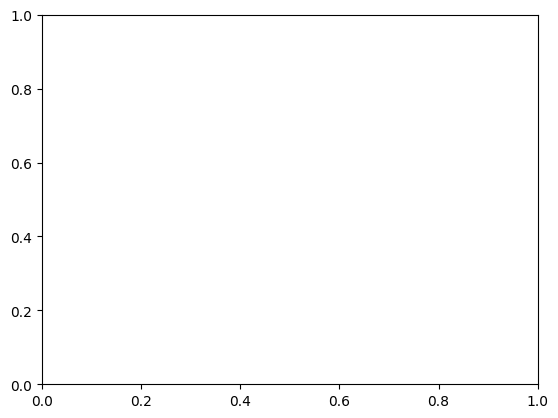

In [100]:
# SA for hydro cf - correlation analysis
f_rand_df = pd.read_csv('hydrocf_rand.csv', index_col=0)
merged_df = hydro_output.merge(cf_rand_df, left_index=True, right_index=True).merge(vre_output, left_index=True, right_index=True)

fig, ax = plt.subplots()
r, p = stats.pearsonr(merged_df['CapacityFactor'], merged_df['hydro'])
sns.lmplot(x='CapacityFactor', y='hydro', data=merged_df)
plt.text(0.5, 1.2, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.title('Hydro output vs. minimum generation')
plt.xlabel('Scaling factor for minimum generation')
plt.ylabel('Total hydro generation (MWh)')

plt.savefig(f'{dest}/hydro_cf_SA.jpg', dpi=300, bbox_inches='tight')
plt.close()


fig, ax = plt.subplots()
r, p = stats.pearsonr(merged_df['CapacityFactor'], merged_df['vre'])
sns.lmplot(x='CapacityFactor', y='vre', data=merged_df)
plt.text(0.5, 0.8, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.title('VRE output vs. hydro minimum generation')
plt.xlabel('Scaling factor for minimum generation')
plt.ylabel('Total VRE generation (MWh)')

plt.savefig(f'{dest}/hydro_cf_VRE_SA.jpg', dpi=300, bbox_inches='tight')
plt.close()


In [113]:
# line capacity vs VRE output
from openpyxl import load_workbook

line_cap_rand = list(engine.random(10))
df_line_cap_rand = pd.DataFrame(line_cap_rand, columns=['line_cap'])
df_line_cap_rand.to_csv('linecap_rand.csv')
list_plants = pd.read_excel(f'{silver_path}/model inputs - BC_cascade_scen14.xlsx', sheet_name='existing transmission')

for i, rand in enumerate(line_cap_rand):
    input_base_file = f'{silver_path}/model inputs - BC_cascade_scen14.xlsx'
    input_new_file  = f'{silver_path}/model inputs - BC_cascade_scen14_sa_lin_{i}.xlsx'
    input_base = pd.read_excel(input_base_file, sheet_name='existing transmission', index_col=0)
    shutil.copy(input_base_file, input_new_file)
    for index, row in input_base.iterrows():
        input_base.loc[index, 'pmax'] = round(row['pmax']*0.7 + row['pmax']*0.3* rand[0], 0)
    wb_target = load_workbook(input_new_file, data_only=False)
    del wb_target['existing transmission']
    writer = pd.ExcelWriter(input_new_file, engine='openpyxl')
    writer.book = wb_target
    input_base.to_excel(writer, sheet_name='existing transmission', index=True)
    writer.close()
    wb_target.close()

/tmp/ipykernel_1216/3406692160.py:19: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = wb_target
/tmp/ipykernel_1216/3406692160.py:19: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = wb_target
/tmp/ipykernel_1216/3406692160.py:19: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = wb_target
/tmp/ipykernel_1216/3406692160.py:19: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = wb_target
/tmp/ipykernel_1216/3406692160.py:19: FutureWarning: Setting the `book` attribute is not part of

In [2]:
# processing sa_lin_files
dest = fixpath(r"C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\validation\SILVER")
for i in range(0,10):
    silver_postprocess(destination_dir=dest, scenario=f'sa_lin_{i}')

/mnt/c/users/smoha/documents/git/etl-visuals/oper_postprocess/post_process.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_uc_vre.loc['total'] = combined_uc_vre.sum()
/mnt/c/users/smoha/documents/git/etl-visuals/oper_postprocess/post_process.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_uc_vre.loc['total'] = combined_uc_vre.sum()
/mnt/c/users/smoha/documents/git/etl-visuals/oper_postprocess/post_process.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/SILVER_BC_Cascade/SILVER_Data/Model Results/BC_Cascade_sa_lin_10'

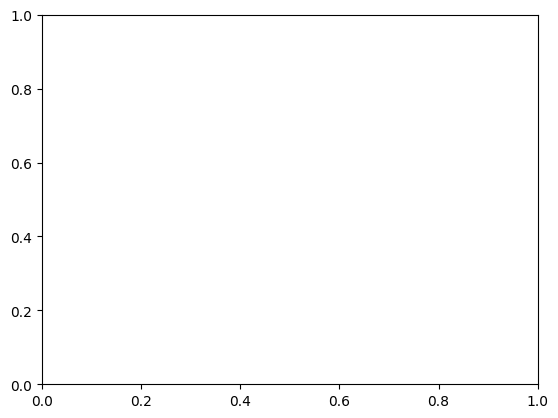

In [9]:
# SA for line_cap - reading outputs + analyzing
vre_output = pd.DataFrame(columns=['vre'])

for i in range (0, 10):
    gen_output = pd.read_excel(f'{dest}/sa_lin_{i}/analysis_BC_Cascade_sa_lin_{i}.xlsx', sheet_name='Total Dispatch', index_col=0)
    vre_output.loc[i] = gen_output.at['total', 'Wind'] + gen_output.at['total', 'Solar']

lin_rand_df = pd.read_csv(f'{file_path}/linecap_rand.csv', index_col=0)
merged_df = vre_output.merge(lin_rand_df, left_index=True, right_index=True)

fig, ax = plt.subplots()
r, p = stats.pearsonr(merged_df['line_cap'], merged_df['vre'])
sns.lmplot(x='line_cap', y='vre', data=merged_df)
plt.text(0.5, 1.2, 'r={:.2f}'.format(r), transform=ax.transAxes)
plt.title('VRE outpu compared rto line capacity')
plt.xlabel('Scaling factor for line capacity (0.7 to 1)')
plt.ylabel('Total vre generation (MWh)')

plt.savefig(f'{dest}/vre_line_SA.jpg', dpi=300, bbox_inches='tight')
plt.close()